In [89]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from skimage.color import rgb2gray
from skimage.draw import disk
from matplotlib.patches import Circle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import re

In [90]:
def key_from_csv(p: Path) -> str:
    """
    C2...nd2_(series_01)_0233-0247.csv  ->  C2...nd2_(series_01)
    """
    name = p.stem  # no .csv
    # remove trailing _####-#### (or similar) if present
    name = re.sub(r"_\d+-\d+$", "", name)
    return name

def key_from_img(p: Path) -> str:
    """
    C2...nd2_(series_01).jpg -> C2...nd2_(series_01)
    """
    return p.stem  # no .jpg


In [91]:
image_path = "examples/C2_MP_U2OS_fixed_20nMJF549_ORC1_MGS1.nd2_(series_01).tif"

In [92]:
image = Image.open(image_path).convert("RGB")
gray = rgb2gray(image)

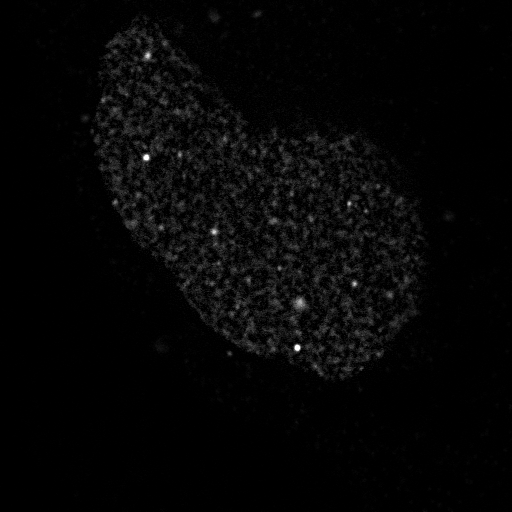

In [93]:
image

# Functions

In [ ]:
def scatter_plot(df, x_col, y_col, 
                 x_lim=None, 
                 y_lim=None):

    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)

    plt.xlabel(x_col.replace("_", " "))
    plt.ylabel(y_col.replace("_", " "))

    # Fixed scale
    if x_lim is not None:
        plt.xlim(x_lim)

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()



def plot_histogram(df, column, bins=50, xlabel=None, title=None,
                   figsize=(4, 3), dpi=200):
    """
    Plot histogram for a dataframe column.

    Parameters:
    df : pandas.DataFrame
    column : str
        Column name to plot
    bins : int
        Number of bins
    xlabel : str (optional)
    title : str (optional)
    """

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.hist(
        df[column].dropna(),
        bins=bins,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8
    )

    ax.set_xlabel(xlabel if xlabel else column, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(title if title else f"Distribution of {column}", fontsize=12)

    # Clean style
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_foci_on_image(
    gray_image,
    df,
    x_col="x_px",
    y_col="y_px",
    r_col="sigma_px",
    circle_color="red",
    center_size=6,
    linewidth=1,
    figsize=(7, 7),
    show=True
):
    """
    Plot detected foci as circles on a grayscale image.

    Parameters
    ----------
    gray_image : 2D numpy array
        Grayscale image.
    df : pandas DataFrame
        DataFrame containing coordinates and radii.
    x_col, y_col : str
        Column names for x and y coordinates.
    r_col : str
        Column name for radius (in pixels).
    circle_color : str
        Color of circle and center dot.
    center_size : int
        Size of center dot.
    linewidth : int
        Circle outline thickness.
    figsize : tuple
        Figure size.
    show : bool
        Whether to call plt.show().
    """

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(gray_image, cmap="gray")

    for x_px, y_px, r_px in zip(df[x_col], df[y_col], df[r_col]):
        # circle outline
        ax.add_patch(
            Circle(
                (x_px, y_px),
                r_px,
                fill=False,
                edgecolor=circle_color,
                linewidth=linewidth
            )
        )
        # center dot
        ax.scatter(x_px, y_px, c=circle_color, s=center_size)

    ax.axis("off")

    if show:
        plt.show()

    return fig, ax



# Data import

In [ ]:
path_data = "./examples/file_extent.csv"
#path_data2= "./examples/file2.csv"
#path_image = "./examples/image.jpg"

In [ ]:
df = pd.read_csv(path_data, encoding="latin1")
df.head()
print("Intial number of foci: ", df.shape[0])


## Filtration based on sigma value

In [ ]:
df = df[(df["sigma [nm]"] > 75)]
print("Number of foci after filtration: ", df.shape[0])


## Calculate number of outliers based on MFI of foci

In [ ]:
data = df["mean_intensity"]
mean = data.mean()
std = data.std()
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = df[df["mean_intensity"] > upper_bound]
print("Number of outliers: ", outliers.shape[0])

In [ ]:
df["Outlier"] = False

In [ ]:
df["Outlier"] = df["mean_intensity"] > upper_bound

In [ ]:
sum(df["Outlier"])

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.hist(data, bins=50, alpha=0.6)
plt.axvline(upper_bound, linestyle="--", linewidth=2)

plt.xlabel("Mean intensity")
plt.ylabel("Frequency")
plt.title("")

plt.show()

In [ ]:
# open image
#image = Image.open(path_image).convert("RGB")
#image

## Draw circle area

In [105]:
df = pd.read_csv("./examples/run/C2_MP_U2OS_fixed_20nMJF549_ORC1_MGS1.nd2_(series_01)_0199-0257.csv")

In [106]:
df

,id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm]
0,1,5348.63945,7656.59629,45.47298,1411.61256,7.25550
1,2,5681.25918,8893.63029,71.72895,1313.57920,12.61756
2,3,5664.00179,8115.08397,105.36936,6466.30563,8.95652
3,4,5740.10787,6716.86459,77.62390,2201.61762,14.41114
4,5,5741.64056,6262.88435,48.19687,965.92339,7.66627
...,...,...,...,...,...,...
1094,1095,24336.00235,16767.29066,50.33813,583.92079,12.64385
1095,1096,24343.53913,13274.47829,73.58188,1704.38981,10.16373
1096,1097,24353.75436,13783.46585,59.89103,2027.68462,8.17590
1097,1098,24373.03905,15766.59886,34.80760,397.39191,11.56320


In [99]:
px_size_ts_x = 11.6
px_size_ts_y = 11.6

px_size_x = 57.5
px_size_y = 58.7

sx = px_size_ts_x/px_size_x
sy = px_size_ts_y/px_size_y
ssigma = np.mean([px_size_ts_x, px_size_ts_y]) / np.mean([px_size_x, px_size_y])


df["x_px"] = sx*df["x_nm"] / px_size_ts_x
df["y_px"] = sy*df["y_nm"] / px_size_ts_y

# For sigma (use average pixel size)
df["sigma_px"] = ssigma*df["sigma_nm"] / np.mean([px_size_ts_x, px_size_ts_y])

In [102]:
gray.shape

(512, 512)

In [ ]:
def compute_mean_intensity_from_localizations(
        image_path,
        df,
        px_size_ts_x = 11.6,
        px_size_ts_y = 11.6,
        px_size_x = 57.5,
        px_size_y = 58.7,
        x_col="x [nm]",
        y_col="y [nm]",
        sigma_col="sigma [nm]"
    ):

        # Open image
        image = Image.open(image_path).convert("RGB")

        # Convert image to grayscale
        gray = rgb2gray(image)
        H, W = gray.shape # number of pixels

        # Scaling factors
        sx = px_size_ts_x/px_size_x
        sy = px_size_ts_y/px_size_y
        ssigma = np.mean([px_size_ts_x, px_size_ts_y]) / np.mean([px_size_x, px_size_y])

        # Storage lists
        x_list = []
        y_list = []
        sigma_list = []
        mean_list = []

        for _, row in df.iterrows():
            x_nm = row[x_col]
            y_nm = row[y_col]
            sigma_nm = row[sigma_col]

            # original pixels → current image pixels
            x_px = int(round(sx * x_nm / px_size_ts_x))
            y_px = int(round(sy * y_nm / px_size_ts_y))
            sigma_px = max(1, int(round(ssigma * sigma_nm / np.mean([px_size_ts_x, px_size_ts_y])))) # minimal possible value is 1 pixel!

            # Build circular mask (clipped automatically)
            rr, cc = disk((y_px, x_px), sigma_px, shape=(H, W))
            mask = np.zeros((H, W), dtype=bool)
            mask[rr, cc] = True
            disk((y_px, x_px), sigma_px, shape=(H, W))

            # Compute mean intensity
            if mask.sum() > 0:
                mean_intensity = gray[mask].mean()
            else:
                mean_intensity = np.nan

            x_list.append(x_px)
            y_list.append(y_px)
            sigma_list.append(sigma_px)
            mean_list.append(mean_intensity)

        # Return modified copy
        df_out = df.copy()
        df_out["x_px"] = x_list
        df_out["y_px"] = y_list
        df_out["sigma_px"] = sigma_list
        df_out["mean_intensity"] = mean_list

        return df_out

In [113]:
res = compute_mean_intensity_from_localizations(
        image_path = "./examples/C2_MP_U2OS_fixed_20nMJF549_ORC1_MGS1.nd2_(series_01).tif",
        df = df,
        px_size_ts_x = 11.6,
        px_size_ts_y = 11.6,
        px_size_x = 57.5,
        px_size_y = 58.7,
        x_col="x [nm]",
        y_col="y [nm]",
        sigma_col="sigma [nm]"
    )

[130] [93]
[152] [99]
[137 137 137 138 138 138 139 139 139] [ 98  99 100  98  99 100  98  99 100]
[114] [100]
[107] [100]
[115 115 115 116 116 116 117 117 117] [ 98  99 100  98  99 100  98  99 100]
[136] [98]
[58] [102]
[72] [101]
[84] [101]
[77] [103]
[149 149 149 149 149 150 150 150 150 150 151 151 151 151 151 152 152 152
 152 152 153 153 153 153 153] [101 102 103 104 105 101 102 103 104 105 101 102 103 104 105 101 102 103
 104 105 101 102 103 104 105]
[165 165 165 166 166 166 167 167 167] [103 104 105 103 104 105 103 104 105]
[165 165 165 166 166 166 167 167 167] [103 104 105 103 104 105 103 104 105]
[ 99  99  99 100 100 100 101 101 101] [104 105 106 104 105 106 104 105 106]
[122 122 122 123 123 123 124 124 124] [104 105 106 104 105 106 104 105 106]
[152] [103]
[93] [105]
[88] [107]
[86] [108]
[176] [107]
[45] [111]
[106] [108]
[118] [109]
[141 141 141 142 142 142 143 143 143] [107 108 109 107 108 109 107 108 109]
[151] [108]
[55] [111]
[65] [111]
[97] [110]
[42 42 42 43 43 43 44 44

In [110]:
res

,id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm],x_px,y_px,sigma_px,mean_intensity
0,1,5348.63945,7656.59629,45.47298,1411.61256,7.25550,93,130,1,0.133333
1,2,5681.25918,8893.63029,71.72895,1313.57920,12.61756,99,152,1,0.145098
2,3,5664.00179,8115.08397,105.36936,6466.30563,8.95652,99,138,2,0.122440
3,4,5740.10787,6716.86459,77.62390,2201.61762,14.41114,100,114,1,0.039216
4,5,5741.64056,6262.88435,48.19687,965.92339,7.66627,100,107,1,0.050980
...,...,...,...,...,...,...,...,...,...,...
1094,1095,24336.00235,16767.29066,50.33813,583.92079,12.64385,423,286,1,0.015686
1095,1096,24343.53913,13274.47829,73.58188,1704.38981,10.16373,423,226,1,0.000000
1096,1097,24353.75436,13783.46585,59.89103,2027.68462,8.17590,424,235,1,0.000000
1097,1098,24373.03905,15766.59886,34.80760,397.39191,11.56320,424,269,1,0.000000


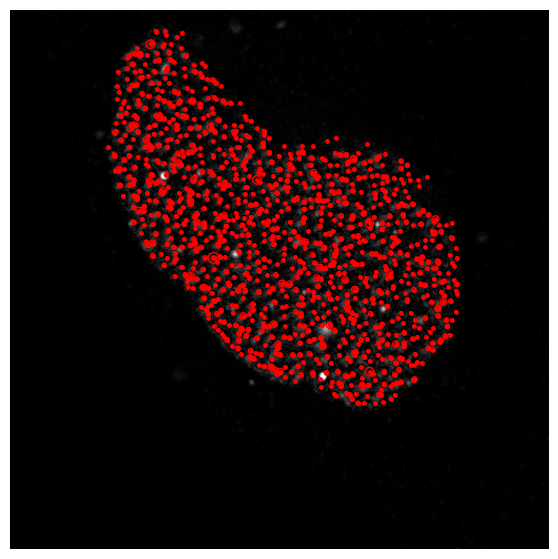

In [111]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(res["x_px"], res["y_px"], res["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

In [ ]:
df.head()

# Kmean

In [ ]:
n_clusters = 3

# Select TWO columns
X = df[["mean_intensity", "sigma [nm]"]].dropna()

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels back to dataframe
df.loc[X.index, "cluster"] = labels

centers = kmeans.cluster_centers_

print("Cluster centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: mean_intensity={c[0]:.2f}, sigma={c[1]:.2f}")

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(5, 4), dpi=200)

# Scatter plot of clusters
for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    plt.scatter(cluster_data["sigma [nm]"],
                cluster_data["mean_intensity"],
                alpha=0.6,
                label=f"Cluster {cluster_id}")

# Plot cluster centers
plt.scatter(centers[:, 1],   # sigma
            centers[:, 0],   # mean_intensity
            marker="X",
            s=200,
            linewidths=2,
            edgecolors="black",
            label="Centers")

plt.xlabel("Sigma")
plt.ylabel("Mean intensity")
plt.title("KMeans Clustering (Sigma vs Intensity)")
plt.legend()

# Clean look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
plot_histogram(df, column="sigma [nm]", xlabel="Sigma (nm)", title="Distribution of Sigma")

Task:
1. sigma - 2 populations (KMeans)
2. Outliers of sigma - check them:
 - big bright dots: analyze as a third population
 - aggregates: analyze separatly
 - MFI of nucleus - big dots/aggregates
3. How the bg susbstruction affects the sigma, MFI of foci?

In [ ]:
means = df.groupby("sigma [nm]")["mean_intensity"].mean()
plt.bar(means.index, means.values)
plt.xlabel("sigma [nm]")
plt.ylabel("Mean intensity")
plt.xticks(rotation=45)
plt.show()

# Filtration

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])